In [1]:
from collections import namedtuple
import csv
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/MyDrive/DataScience/SigTupleAssignment/Oxford_PetDataset/annotations/'

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [4]:
data_images = '/content/drive/MyDrive/DataScience/SigTupleAssignment/Oxford_PetDataset/images'
data_classlist = "/content/drive/MyDrive/DataScience/SigTupleAssignment/Oxford_PetDataset/annotations/list.txt"
data_xmlAnnotations = '/content/drive/MyDrive/DataScience/SigTupleAssignment/Oxford_PetDataset/annotations/xmls'
TARGET_SIZE = (224, 224)

In [5]:
Bounding_Box = namedtuple('Bounding_Box', 'xmin ymin xmax ymax')


def building_bounding_box(path_xml_annotation):
    tree = ET.parse(path_xml_annotation)
    root = tree.getroot()
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)
    return Bounding_Box(xmin, ymin, xmax, ymax)

In [6]:
def resize_image_with_bounds(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2
        
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad + bonus_w_pad, h_pad + bonus_h_pad))
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad

    if target_size is not None:
        width, height = image.size
        image = image.resize(target_size)
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height
    if bounding_box is not None:
        new_xmin = new_xmin * width_scale
        new_xmax = new_xmax * width_scale
        new_ymin = new_ymin * height_scale
        new_ymax = new_ymax * height_scale

    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    if bounding_box is None:
        return image_data, None
    return image_data, Bounding_Box(new_xmin, new_ymin, new_xmax, new_ymax)

In [7]:
def setting_sample_from_name(sample_name):
    path_to_image = os.path.join(data_images, sample_name + '.jpg')
    path_to_xml = os.path.join(data_xmlAnnotations, sample_name + '.xml')
    original_bounding_box = building_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)
    return (image_data, bounding_box)

In [8]:
def plot_with_box(image_data, bounding_box, compare_box=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image_data)
    # Creating a Rectangle patch for the changed one
    boxA = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
                             bounding_box.xmax - bounding_box.xmin,
                             bounding_box.ymax - bounding_box.ymin,
                             linewidth=3, edgecolor='y', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(boxA)
    # Creating another Rectangular patch for the real one
    if compare_box is not None:
        boxB = patches.Rectangle((compare_box.xmin, compare_box.ymin),
                                 compare_box.xmax - compare_box.xmin,
                                 compare_box.ymax - compare_box.ymin,
                                 linewidth=2, edgecolor='b', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(boxB)
        xA = max(bounding_box.xmin, compare_box.xmin)
        yA = max(bounding_box.ymin, compare_box.ymin)
        xB = min(bounding_box.xmax, compare_box.xmax)
        yB = max(bounding_box.ymax, compare_box.ymax)
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (bounding_box.xmax - bounding_box.xmin + 1) * (bounding_box.ymax - bounding_box.ymin + 1)
        boxBArea = (compare_box.xmax - compare_box.xmin + 1) * (compare_box.ymax - compare_box.ymin + 1)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        
        print('intersection of union =', iou)
    plt.show()

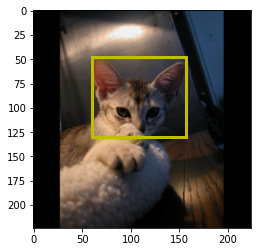

In [9]:
sample_name = 'Abyssinian_10'
image, bounding_box = setting_sample_from_name(sample_name)
plot_with_box(image, bounding_box)

In [10]:
data_pros = []
with open(data_classlist) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    for row in csv_reader:
        if row[0].startswith('#'):
            continue
        sample_name, class_id, species, breed_id = row
        try:
            image, bounding_box = setting_sample_from_name(sample_name)
        except FileNotFoundError:
            continue
        # cat = 0 and dog = 1.
        data_tuple = (image, int(species) - 1, bounding_box)
        data_pros.append(data_tuple)
    print(f'Processed {len(data_pros)} samples')
    data_pros = np.array(data_pros)

Processed 3671 samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


2549 it is dog


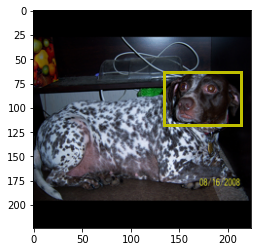

2292 it is cat


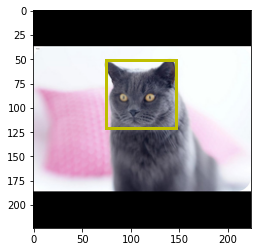

3480 it is cat


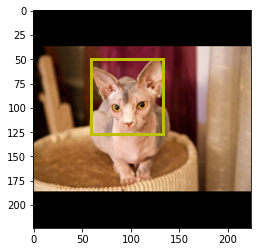

1548 it is dog


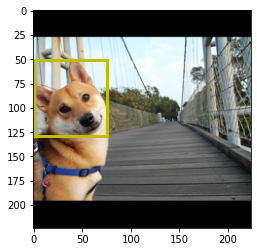

860 it is dog


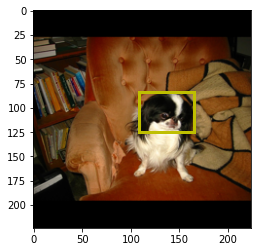

482 it is cat


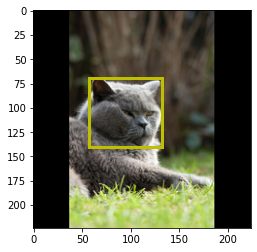

In [11]:
for _ in range(6):
    i = np.random.randint(len(data_pros))
    image, species, bounding_box = data_pros[i]
    if species == 0:
        print(i, "it is cat")
    elif species == 1:
        print(i, "it is dog")
    else:
        print("ERROR FOUND: This is of invalid species type")
    plot_with_box(image, bounding_box)

In [12]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data_pros, test_size=0.2, random_state=42, shuffle=True)

In [13]:
print(train.shape)
print(valid.shape)

(2936, 3)
(735, 3)


In [14]:
x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []

for image, species, bounding_box in train:
  x_train.append(preprocess_input(image))
  y_class_train.append(species)
  y_box_train.append(bounding_box)

for image, species, bounding_box in valid:
  x_validation.append(preprocess_input(image))
  y_class_validation.append(species)
  y_box_validation.append(bounding_box)

x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)
x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)
localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])
# model.summary()

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
batchsize = 64
model.compile(optimizer='adam', metrics=['accuracy'],loss=['binary_crossentropy', 'mse'])
#lets run it through 10 epochs
history1=model.fit(x_train, [y_class_train, y_box_train], validation_data=(x_validation, [y_class_validation, y_box_validation]),
                         epochs=16,verbose=True, batch_size=batchsize)

model.save('/content/drive/MyDrive/DataScience/SigTupleAssignment/Oxford_PetDataset/models/model_mobilenet_16epo.h5')

Epoch 1/16
46/46 [==============================] - 44s 646ms/step - loss: 1045.5260 - dense_loss: 0.6619 - dense_1_loss: 1044.8643 - dense_accuracy: 0.6298 - dense_1_accuracy: 0.7718 - val_loss: 932.8726 - val_dense_loss: 1.5923 - val_dense_1_loss: 931.2803 - val_dense_accuracy: 0.3497 - val_dense_1_accuracy: 0.8150
Epoch 2/16
46/46 [==============================] - 27s 591ms/step - loss: 218.0659 - dense_loss: 0.5875 - dense_1_loss: 217.4785 - dense_accuracy: 0.6880 - dense_1_accuracy: 0.8661 - val_loss: 393.6213 - val_dense_loss: 1.4813 - val_dense_1_loss: 392.1400 - val_dense_accuracy: 0.3619 - val_dense_1_accuracy: 0.8422
Epoch 3/16
46/46 [==============================] - 27s 590ms/step - loss: 110.3270 - dense_loss: 0.5613 - dense_1_loss: 109.7657 - dense_accuracy: 0.7105 - dense_1_accuracy: 0.9012 - val_loss: 382.1814 - val_dense_loss: 1.9021 - val_dense_1_loss: 380.2794 - val_dense_accuracy: 0.3524 - val_dense_1_accuracy: 0.8259
Epoch 4/16
46/46 [=============================

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [17]:
def plot_training_history(history, model):
  plt.plot(history.history['dense_1_accuracy'])
  plt.plot(history.history['val_dense_1_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
  plt.plot(history.history['dense_1_loss'])
  plt.plot(history.history['val_dense_1_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()

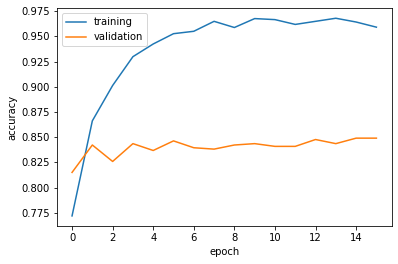

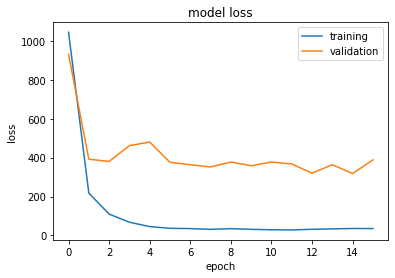

In [18]:
plot_training_history(history1, model)

it is a Cat
intersection of union = 0.6076635820171356


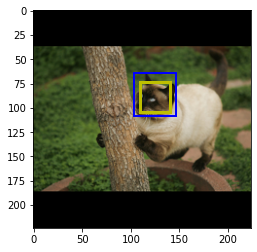

it is a dog
intersection of union = 0.2557373886151131


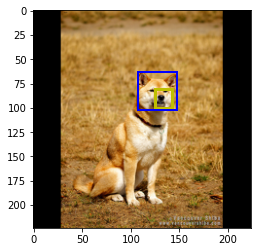

it is a Cat
intersection of union = 0.783918528807216


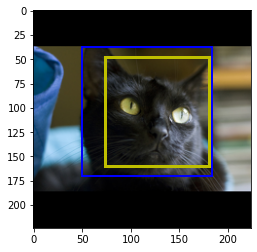

it is a Cat
intersection of union = 0.8040229201186581


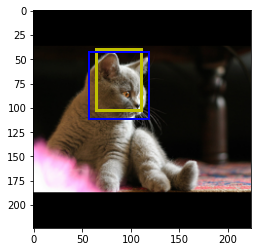

it is a dog
intersection of union = 0.3845974904101931


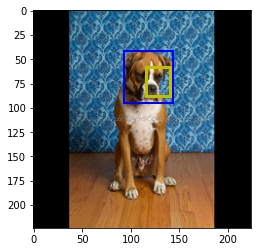

it is a Cat
intersection of union = 0.7451980823120208


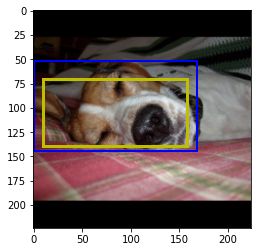

it is a Cat
intersection of union = 0.6153233810957439


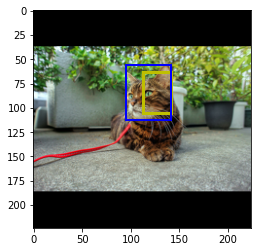

it is a Cat
intersection of union = 0.5924635466206843


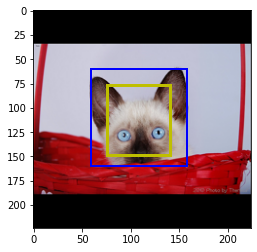

it is a Cat
intersection of union = 0.7780513402541057


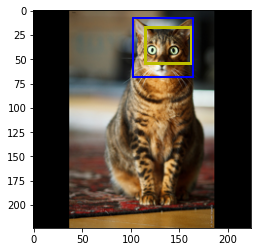

it is a dog
intersection of union = 0.8933522416908488


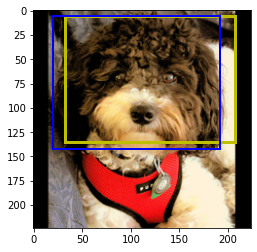

it is a Cat
intersection of union = 0.869933611155864


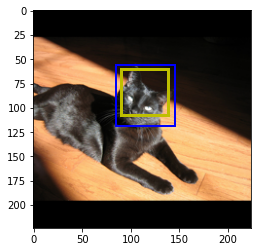

it is a Cat
intersection of union = 0.6841236527193026


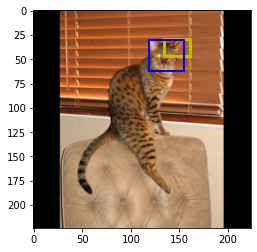

it is a Cat
intersection of union = 0.4386123614472151


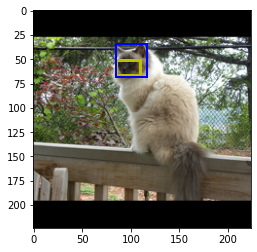

it is a Cat
intersection of union = 0.7445229609762847


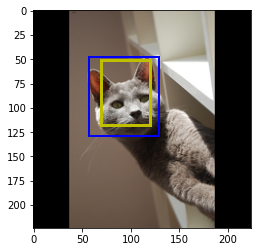

it is a Cat
intersection of union = 1.0234753390695008


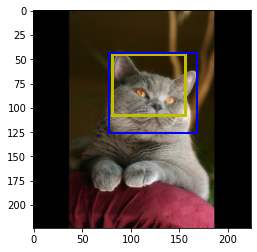

it is a dog
intersection of union = 0.5184190545447178


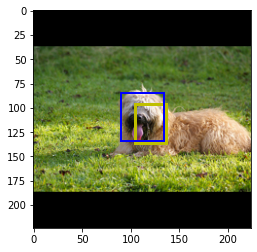

it is a dog
intersection of union = 0.6891776353608369


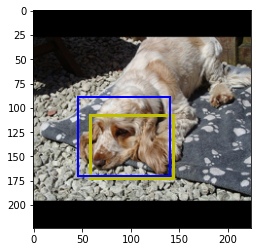

it is a Cat
intersection of union = 0.6000622278690562


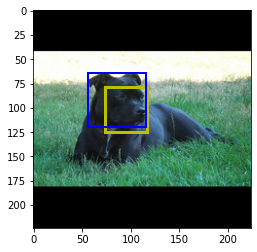

In [20]:
from keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/DataScience/SigTupleAssignment/Oxford_PetDataset/models/model_mobilenet_16epo.h5')

for _ in range(18):
  i = np.random.randint(len(data_pros))
  img, species, true_bounding_box = data_pros[i]
  pred = model.predict(np.array([preprocess_input(img)]))
  if pred[0][0] < .5:
    print("it is a Cat")
  else:
    print("it is a dog")
  plot_with_box(img, Bounding_Box(*pred[1][0]), true_bounding_box)
